In [21]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/test_data.csv")

In [3]:
# 'Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(

Dispenser_num 변수 정리

In [4]:
train_data['Dispenser_num'].value_counts()

Dispenser_num
#1    25011
#2    15461
#0       34
Name: count, dtype: int64

In [5]:
# Dispenser_num 값에 따라 원핫인코딩 변수 생성
train_data['Dispenser_1'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
train_data['Dispenser_2'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

test_data['Dispenser_1'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
test_data['Dispenser_2'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

# 결과 확인
print(train_data[['Dispenser_num', 'Dispenser_1', 'Dispenser_2']].head(5))

# 불필요한 변수 제거
train_data.drop(['Dispenser_num'], axis=1, inplace=True)
test_data.drop(['Dispenser_num'], axis=1, inplace=True)

  Dispenser_num  Dispenser_1  Dispenser_2
0            #1            1            0
1            #1            1            0
2            #2            0            1
3            #2            0            1
4            #1            1            0


In [8]:
train_data

,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Dispenser_1,Dispenser_2
0,AJX75334505,4F1XA938-1,240,2.5,-90,100,1030,-90,16,14.9,...,243.7,114.612,19.9,7,127,1,NaN,Normal,1,0
1,AJX75334505,3KPM0016-2,240,2.5,-90,70,1030,-90,10,21.3,...,243.7,85.000,19.6,7,185,1,0.0,Normal,1,0
2,AJX75334501,4E1X9167-1,1000,12.5,90,85,280,90,16,14.7,...,243.5,114.612,19.8,10,73,1,NaN,Normal,0,1
3,AJX75334501,3K1X0057-1,1000,12.5,90,70,280,90,10,21.3,...,243.5,85.000,19.9,12,268,1,0.0,Normal,0,1
4,AJX75334501,3HPM0007-1,240,2.5,-90,70,1030,-90,10,9.7,...,243.7,85.000,19.7,8,121,1,0.0,Normal,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,240,2.5,-90,70,1030,-90,10,17.0,...,243.7,85.000,19.2,1,318,1,0.0,Normal,1,0
40502,AJX75334501,4E1XC796-1,1000,12.5,90,100,280,90,16,14.9,...,243.5,114.612,20.5,14,197,1,NaN,Normal,0,1
40503,AJX75334501,4C1XD438-1,240,2.5,-90,100,1030,-90,16,14.2,...,243.7,85.000,19.7,1,27,1,NaN,Normal,1,0
40504,AJX75334501,3I1XA258-1,1000,12.5,90,70,280,90,10,9.7,...,243.5,85.000,20.1,13,117,1,0.0,Normal,0,1


target 변수 0,1로 변환

In [14]:
# 타겟 변수를 0과 1로 변환
train_data['target_binary'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

# Workorder 변수의 값에 대한 타겟 변수 비율 계산
workorder_target_ratio = train_data.groupby('Workorder')['target_binary'].mean()

# 파생 변수 생성 함수
def create_derived_variable(row, ratio_dict, threshold):
    return 1 if ratio_dict.get(row['Workorder'], 0) >= threshold else 0

# 파생 변수 생성
train_data['Workorder_0.9'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
train_data['Workorder_0.7'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.7)
train_data['Workorder_0.5'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.5)
train_data['Workorder_0.3'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.3)

test_data['Workorder_0.9'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
test_data['Workorder_0.7'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.7)
test_data['Workorder_0.5'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.5)
train_data['Workorder_0.3'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.3)



In [15]:
train_data['Workorder_0.3'].value_counts()

Workorder_0.3
0    40351
1      155
Name: count, dtype: int64

In [16]:
# 불필요한 변수 제거
train_data.drop(['target_binary'], axis=1, inplace=True)

# train_data.drop(['Workorder', 'target_binary'], axis=1, inplace=True)
# test_data.drop(['Workorder'], axis=1, inplace=True)

In [17]:
train_data.columns.to_list()

['Model.Suffix',
 'Workorder',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_D

receip가 들어간 변수들 하나로 합쳐주기

In [20]:
# 'receipt'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Receip').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
Receip No Collect Result_Dam
Receip No Collect Result_Fill1
Receip No Collect Result_Fill2


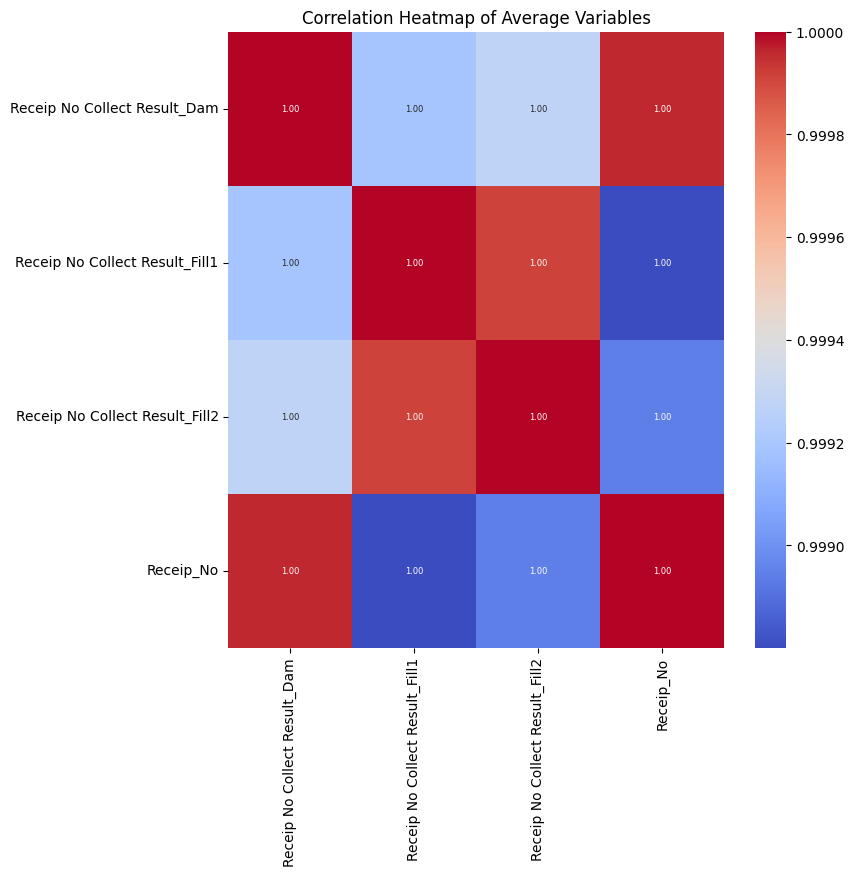

In [28]:
# 상관계수
variables = [
    'Receip No Collect Result_Dam',
    'Receip No Collect Result_Fill1',
    'Receip No Collect Result_Fill2'
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [29]:
# 파생변수 생성: 3개의 컬럼 값이 모두 동일하면 해당 값을 저장, 아니면 diff
train_data['Receip_No'] = train_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)
test_data['Receip_No'] = test_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)

train_data['Receip_No'].value_counts()

Receip_No
1       39276
6         980
9          96
17         86
3          64
diff        4
Name: count, dtype: int64

In [30]:
columns_to_drop = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']

train_data = train_data.drop(columns=columns_to_drop, inplace=False)
test_data = test_data.drop(columns=columns_to_drop, inplace=False)

Workorder 변수 

In [32]:
# 'Workorder' 열에서 '-' 다음 숫자 값 추출 및 '000' 제거
train_data['Workorder'] = train_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)
test_data['Workorder'] = test_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)

Workmode 변수

In [33]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

In [37]:
test_data['WorkMode Collect Result'].value_counts()
train_data['WorkMode Collect Result'].value_counts()

WorkMode Collect Result
0.0    24059
1.0    16447
Name: count, dtype: int64